# 0. Про Антифрод

Как вообще устроен антифрод (на примере фин мониторинга)   

1.   Правила (известные схемы, например из профильных чатов -- для обнала: распыление, слом назначения платежа, вексели, слом ндс, транзит и пр) и экспертные модели (регрессии на известных фичах -- доли контрагентов, коэффициента налоговой нагрузки, корп карты, учредитель - подставное лицо и пр.). Известные фичи "ломаются" уже со стороны нарушителя -- например, КНН можно увеличить отправляя ошибочные платежки в налоговую и получая возвраты
2.   Модели (supervised модели, построенные по отловленным правилами и руками кейсам). Здесь тоже работает PseudoLabelling
3.   Кейс-менеджмент и эксперты (разбор найденных примеров, новых схем, мотивированное суждение). Разбор кейса может занимать, например, 2 недели, включая запрос документов от клиента
4.   Exploration -- unsupervised -- oulier detection -- наша задача найти несколько десятков примеров, передать их на разбор, сделать supervised модель
5.   Мониторинг качества работы и схем и отдельных фичей

мониторинг мошеннических заявок на кредит, определение компаний, искажающих финансовую отчетность -- все это тоже про антифрод.    
на Forex -- фродовыми считаются клиенты, которые выживают и выводят деньги

PS Forensic -- почти синоним

## 0.1 SOTA у академиков

[живое](https://github.com/safe-graph/graph-fraud-detection-papers?tab=readme-ov-file#non-gnn-papers-since-2014-back-to-top)

# 1. Классические алгоритмы

In [ ]:
!pip install pyod combo -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 160.5/160.5 kB 1.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done


In [ ]:
import pyod

Просто [туториал](https://github.com/yzhao062/pyod/blob/master/notebooks/Compare%20All%20Models.ipynb) из самой либы

In [ ]:
from __future__ import division
from __future__ import print_function

import os
import sys
from time import time

# temporary solution for relative imports in case pyod is not installed
# if pyod is installed, no need to use the following line
sys.path.append(
    os.path.abspath(os.path.join(os.path.dirname("__file__"), '..')))

import numpy as np
from numpy import percentile
import matplotlib.pyplot as plt
import matplotlib.font_manager
from sklearn.metrics import recall_score

# Import all models
from pyod.models.abod import ABOD
from pyod.models.cblof import CBLOF
from pyod.models.feature_bagging import FeatureBagging
from pyod.models.hbos import HBOS
from pyod.models.iforest import IForest
from pyod.models.knn import KNN
from pyod.models.lof import LOF
from pyod.models.mcd import MCD
from pyod.models.ocsvm import OCSVM
from pyod.models.pca import PCA
from pyod.models.lscp import LSCP
from pyod.models.inne import INNE
from pyod.models.gmm import GMM
from pyod.models.kde import KDE
from pyod.models.lmdd import LMDD
from pyod.models.vae import VAE

import warnings
warnings.filterwarnings("ignore")

In [ ]:
# Define the number of inliers and outliers
n_samples = 200
outliers_fraction = 0.25
clusters_separation = [0]

# Compare given detectors under given settings
# Initialize the data
xx, yy = np.meshgrid(np.linspace(-7, 7, 100), np.linspace(-7, 7, 100))
n_inliers = int((1. - outliers_fraction) * n_samples)
n_outliers = int(outliers_fraction * n_samples)
ground_truth = np.zeros(n_samples, dtype=int)
ground_truth[-n_outliers:] = 1

# initialize a set of detectors for LSCP
detector_list = [LOF(n_neighbors=5), LOF(n_neighbors=10), LOF(n_neighbors=15),
                 LOF(n_neighbors=20), LOF(n_neighbors=25), LOF(n_neighbors=30),
                 LOF(n_neighbors=35), LOF(n_neighbors=40), LOF(n_neighbors=45),
                 LOF(n_neighbors=50)]

In [ ]:
random_state = np.random.RandomState(42)
# Define nine outlier detection tools to be compared
classifiers = {
    'Angle-based Outlier Detector (ABOD)':
        ABOD(contamination=outliers_fraction),
    'Cluster-based LOF (CBLOF)':
        CBLOF(contamination=outliers_fraction,
              check_estimator=False, random_state=random_state),
    'Feature Bagging':
        FeatureBagging(LOF(n_neighbors=35),
                       contamination=outliers_fraction,
                       random_state=random_state),
    'Histogram-base OD (HBOS)': HBOS(
        contamination=outliers_fraction),
    'Isolation Forest': IForest(contamination=outliers_fraction,
                                random_state=random_state),
    'KNN': KNN(
        contamination=outliers_fraction),
    'Average KNN': KNN(method='mean',
                       contamination=outliers_fraction),
    'Local OF (LOF)':
        LOF(n_neighbors=35, contamination=outliers_fraction),
    'Min Cov Determinant (MCD)': MCD(
        contamination=outliers_fraction, random_state=random_state),
    'One-class SVM (OCSVM)': OCSVM(contamination=outliers_fraction),
    'PCA': PCA(
        contamination=outliers_fraction, random_state=random_state),
    'Locally Selective Combination (LSCP)': LSCP(
        detector_list, contamination=outliers_fraction,
        random_state=random_state),
    'INNE': INNE(contamination=outliers_fraction),
    'GMM': GMM(contamination=outliers_fraction),
    'KDE': KDE(contamination=outliers_fraction),
    'LMDD': LMDD(contamination=outliers_fraction)
}

In [ ]:
# Fit the models with the generated data and
# compare model performances
for i, offset in enumerate(clusters_separation):
    np.random.seed(42)
    # Data generation
    X1 = 0.3 * np.random.randn(n_inliers // 2, 2) - offset
    X2 = 0.3 * np.random.randn(n_inliers // 2, 2) + offset
    X = np.r_[X1, X2]
    # Add outliers
    X = np.r_[X, np.random.uniform(low=-6, high=6, size=(n_outliers, 2))]

    # Fit the model
    plt.figure(figsize=(15, 16))
    for i, (clf_name, clf) in enumerate(classifiers.items()):
        # fit the data and tag outliers
        clf.fit(X)
        scores_pred = clf.decision_function(X) * -1
        y_pred = clf.predict(X)
        threshold = percentile(scores_pred, 100 * outliers_fraction)

        print(i + 1, clf_name, recall_score(ground_truth, y_pred))
        n_errors = (y_pred != ground_truth).sum()
        # plot the levels lines and the points

        Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()]) * -1
        Z = Z.reshape(xx.shape)
        subplot = plt.subplot(4, 4, i + 1)
        subplot.contourf(xx, yy, Z, levels=np.linspace(Z.min(), threshold, 7),
                         cmap=plt.cm.Blues_r)
        # a = subplot.contour(xx, yy, Z, levels=[threshold],
        #                     linewidths=2, colors='red')
        subplot.contourf(xx, yy, Z, levels=[threshold, Z.max()],
                         colors='orange')
        b = subplot.scatter(X[:-n_outliers, 0], X[:-n_outliers, 1], c='white',
                            s=20, edgecolor='k')
        c = subplot.scatter(X[-n_outliers:, 0], X[-n_outliers:, 1], c='black',
                            s=20, edgecolor='k')
        subplot.axis('tight')
        subplot.legend(
            [
                # a.collections[0],
                b, c],
            [
                # 'learned decision function',
                'true inliers', 'true outliers'],
            prop=matplotlib.font_manager.FontProperties(size=10),
            loc='lower right')
        subplot.set_xlabel("%d. %s (errors: %d)" % (i + 1, clf_name, n_errors))
        subplot.set_xlim((-7, 7))
        subplot.set_ylim((-7, 7))
    plt.subplots_adjust(0.04, 0.1, 0.96, 0.94, 0.1, 0.26)
    plt.suptitle("Outlier detection")
plt.show()

1 Angle-based Outlier Detector (ABOD) 0.92
2 Cluster-based LOF (CBLOF) 0.88
3 Feature Bagging 0.98
4 Histogram-base OD (HBOS) 1.0
5 Isolation Forest 1.0
6 KNN 1.0
7 Average KNN 0.94
8 Local Outlier Factor (LOF) 1.0
9 Minimum Covariance Determinant (MCD) 1.0
10 One-class SVM (OCSVM) 1.0
11 PCA 0.94
12 Locally Selective Combination (LSCP) 1.0
13 INNE 0.88
14 GMM 1.0
15 KDE 1.0
16 LMDD 0.88


PYOD на стероидах = [PYTOD](https://github.com/yzhao062/pytod)

## Вопрос: почему ими никто не пользуется?

## Кроме бэггингов конечно, запомните Isolation Forest

## И все-таки они работают, с оглядкой на быстродействие, если ваше пространство фичей хорошее

## Обычный AE

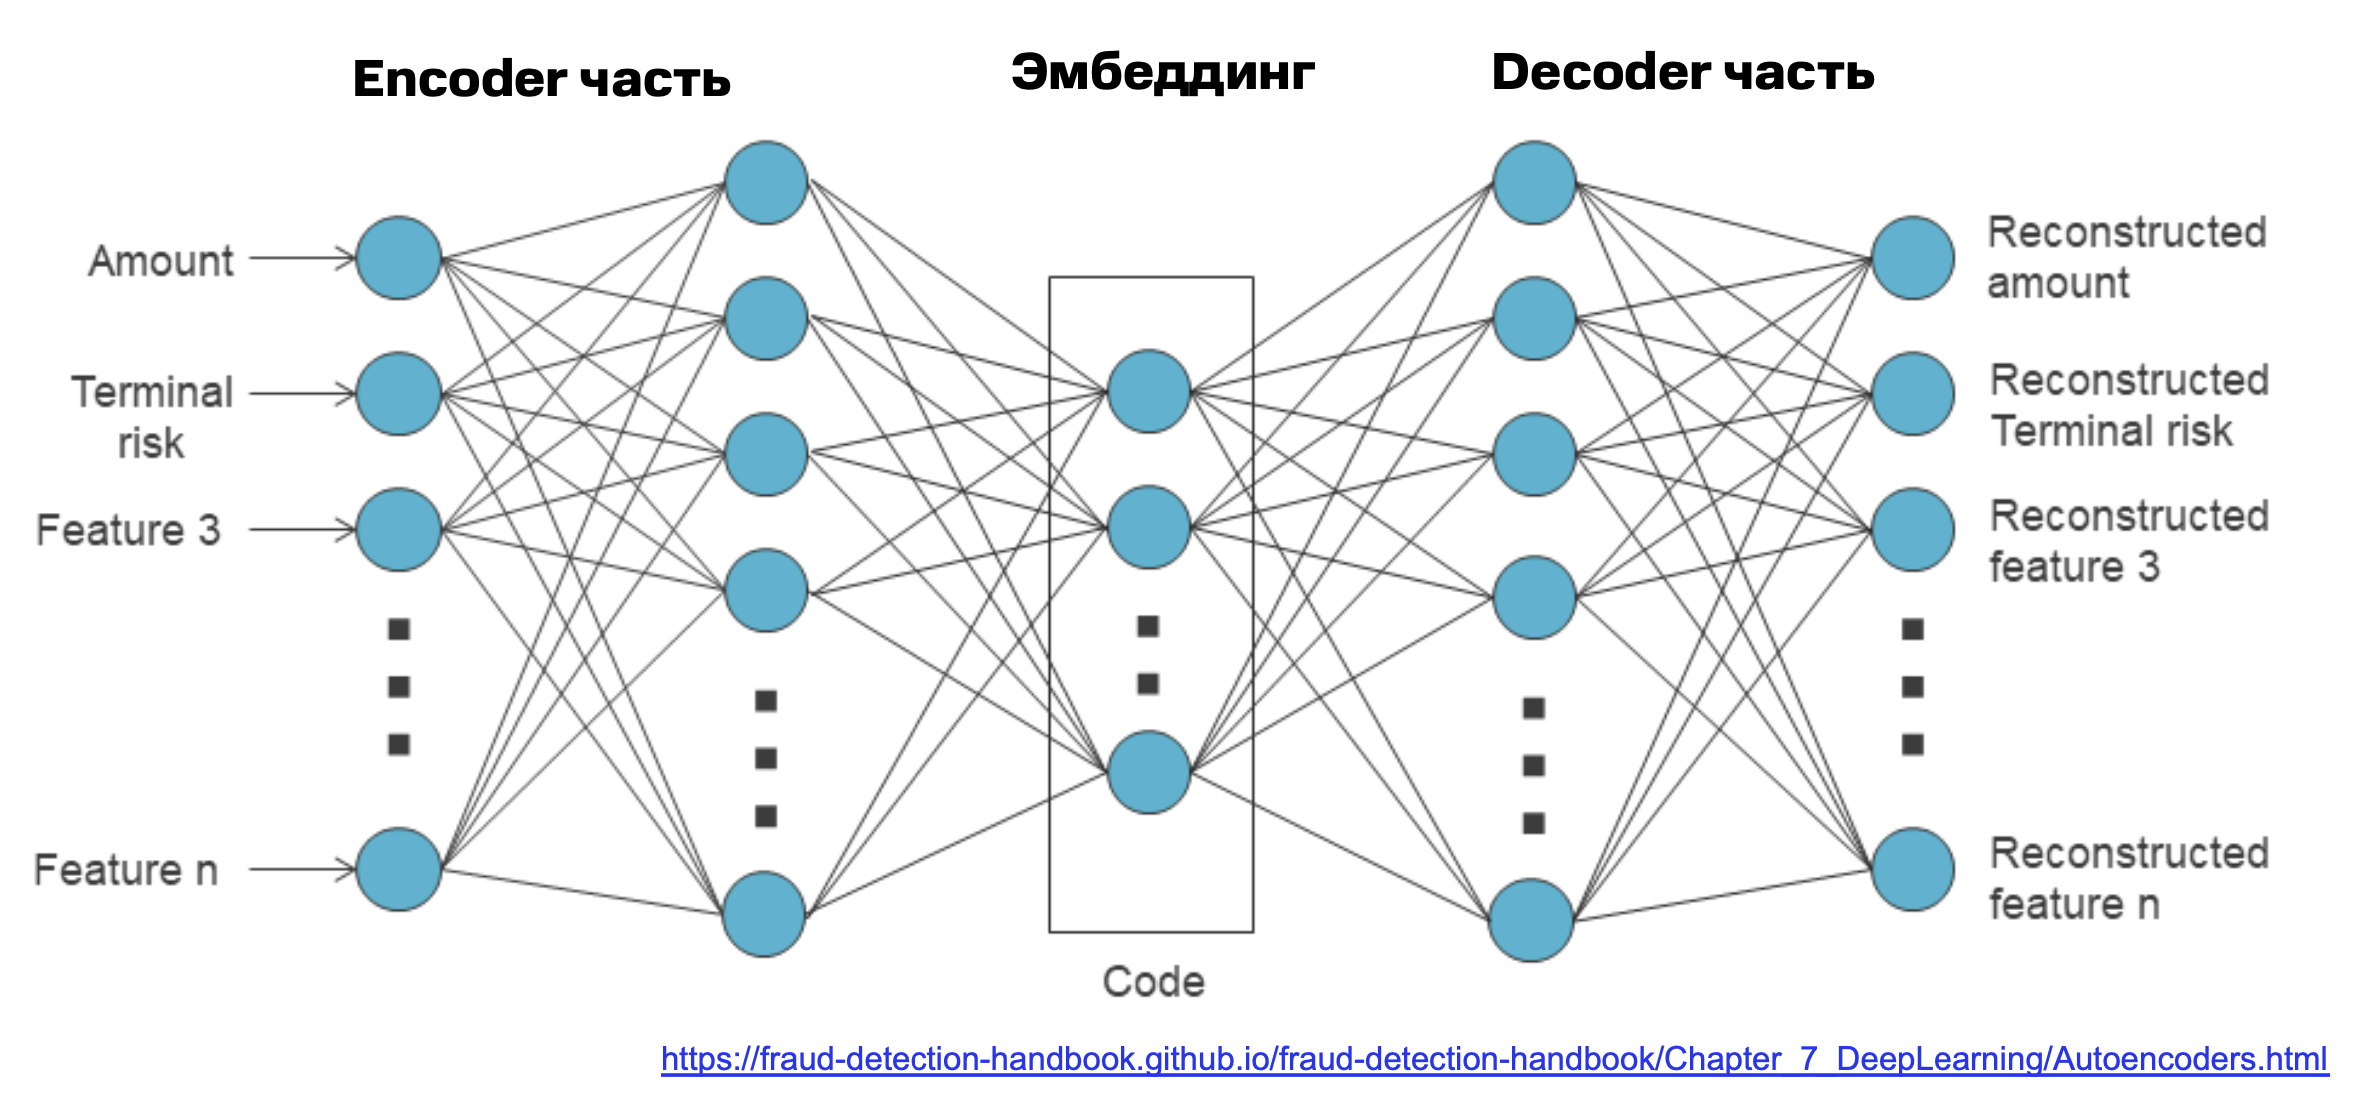



In [ ]:
!git clone https://github.com/yzhao062/pyod.git

Cloning into 'pyod'...
remote: Enumerating objects: 9796, done.
remote: Counting objects: 100% (2813/2813), done.
remote: Compressing objects: 100% (911/911), done.
remote: Total 9796 (delta 2045), reused 2512 (delta 1864), pack-reused 6983
Receiving objects: 100% (9796/9796), 39.98 MiB | 23.28 MiB/s, done.
Resolving deltas: 100% (6956/6956), done.


In [ ]:
import os
os.chdir('./pyod')

In [ ]:
!pip install .

Processing /content/pyod
  Preparing metadata (setup.py) ... done
  Created wheel for pyod: filename=pyod-1.1.4-py3-none-any.whl size=314088 sha256=8d1f82847bc71646f19e523594e2cc558d64893bed462d436700b6949bef6aeb
  Stored in directory: /tmp/pip-ephem-wheel-cache-ifmpocb4/wheels/35/c9/0b/8a9b8ffd2e0c83f12e896f46397c9ed66d9fde731ab2e3e2bd
Successfully built pyod


In [ ]:
from pyod.models.auto_encoder_torch import AutoEncoder

In [ ]:
!git clone https://github.com/jeffprosise/Machine-Learning.git

Cloning into 'Machine-Learning'...
remote: Enumerating objects: 453, done.
remote: Total 453 (delta 0), reused 0 (delta 0), pack-reused 453
Receiving objects: 100% (453/453), 119.70 MiB | 9.80 MiB/s, done.
Resolving deltas: 100% (226/226), done.


In [ ]:
import pandas as pd

data = pd.read_csv('./Machine-Learning/Data/creditcard.zip')
X, ground_truth = data.drop('Class', axis = 1).copy(), data['Class']

In [ ]:
import torch
torch.cuda.is_available()

True

In [ ]:
ae = AutoEncoder(device = 'cuda', epochs = 21)
ae.fit(X)
y_pred = ae.decision_function(X)

InnerAutoencoder(
  (activation): ReLU()
  (encoder): Sequential(
    (linear0): Linear(in_features=30, out_features=64, bias=True)
    (batch_norm0): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU()
    (dropout0): Dropout(p=0.2, inplace=False)
    (linear1): Linear(in_features=64, out_features=32, bias=True)
    (batch_norm1): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu1): ReLU()
    (dropout1): Dropout(p=0.2, inplace=False)
  )
  (decoder): Sequential(
    (linear0): Linear(in_features=32, out_features=64, bias=True)
    (batch_norm0): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU()
    (dropout0): Dropout(p=0.2, inplace=False)
    (linear1): Linear(in_features=64, out_features=30, bias=True)
    (relu1): ReLU()
  )
)
epoch 0: training loss 0.7695026244022728 
epoch 1: training loss 0.7337914162968641 
epoch 2: training loss 0.725948050

In [ ]:
from sklearn.metrics import roc_auc_score
roc_auc_score(ground_truth, y_pred)

0.9526332081286802

In [ ]:
from sklearn.metrics import PrecisionRecallDisplay

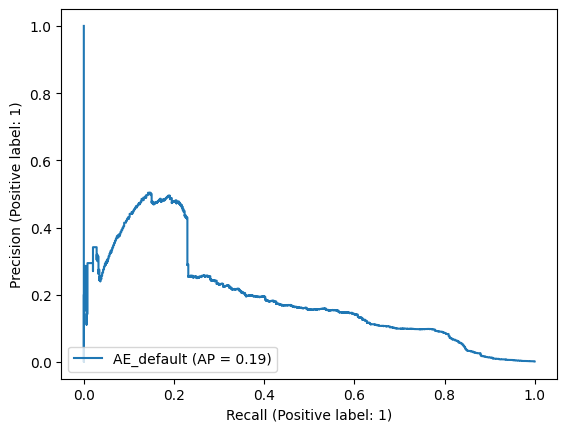

In [ ]:
PrecisionRecallDisplay.from_predictions(ground_truth, y_pred, name="AE_default")

In [ ]:
ground_truth.value_counts()

Class
0    284315
1       492
Name: count, dtype: int64

## ROC AUC не показателен для таких балансов классов!

## VAE

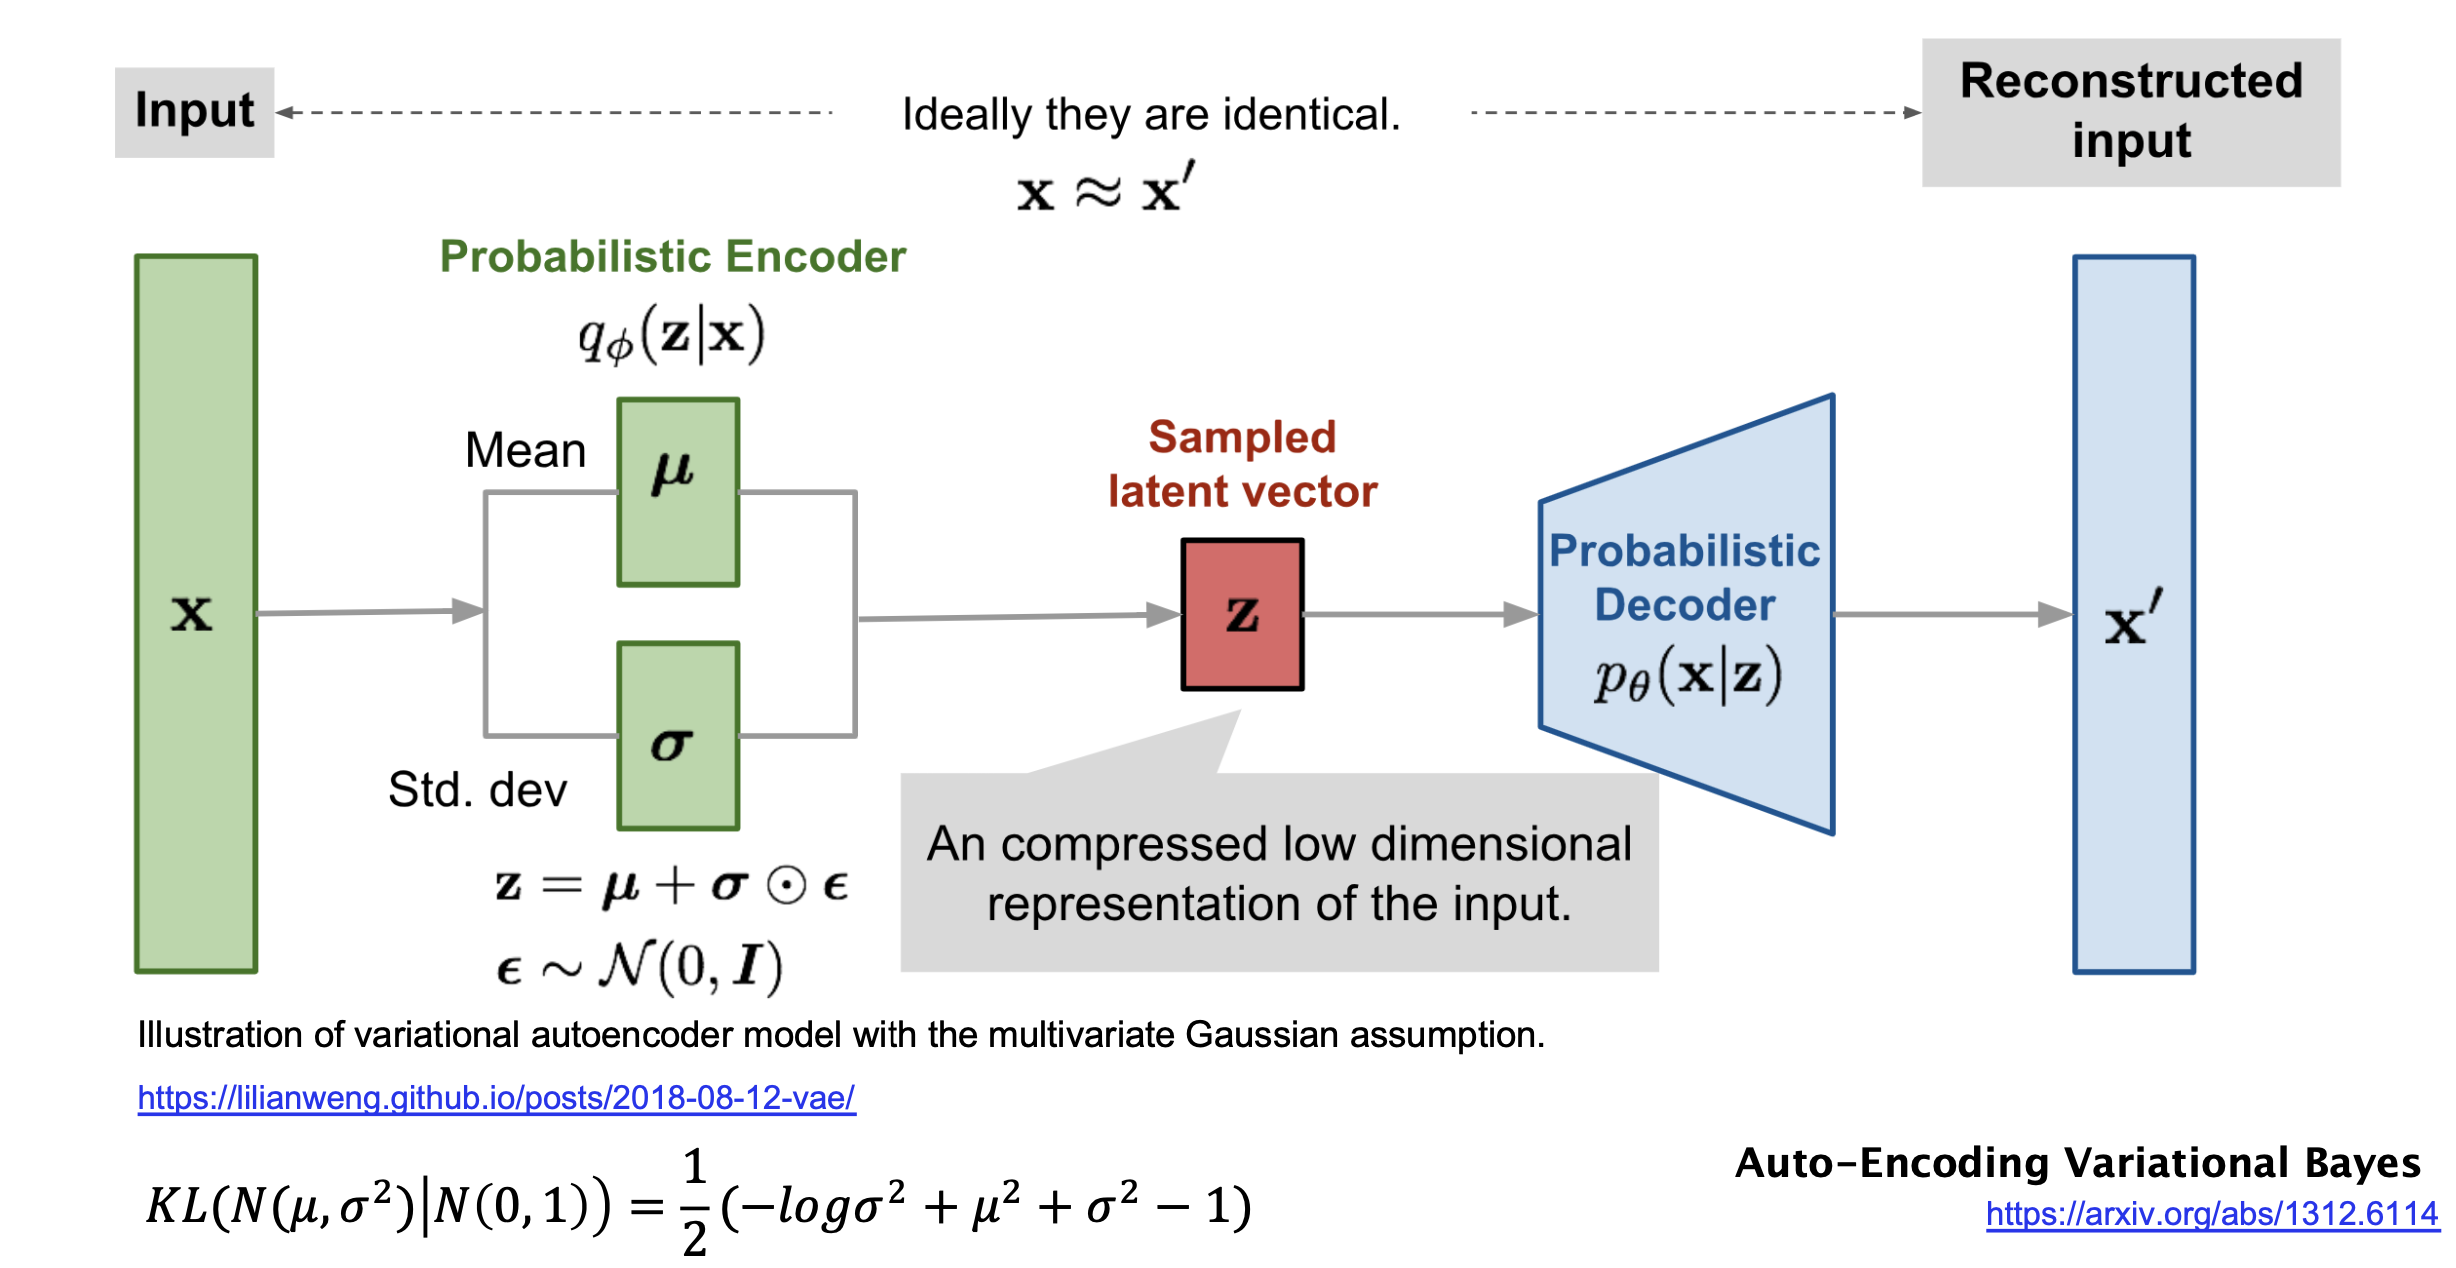

# 2. Алгоритмы детекции аномалий на графах

In [ ]:
import torch
torch.cuda.is_available()

True

In [ ]:
!pip install torch_geometric -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 9.3 MB/s eta 0:00:00


In [ ]:
# Optional dependencies:
!pip install pyg_lib torch_scatter torch_sparse torch_cluster torch_spline_conv -f https://data.pyg.org/whl/torch-2.2.0+cpu.html -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 28.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 508.1/508.1 kB 42.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 12.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 770.0/770.0 kB 52.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 213.9/213.9 kB 28.2 MB/s eta 0:00:00


In [ ]:
# можно ставить и через !pip install pygod
# но нам нужны бенчмарки, поэтому так

!git clone https://github.com/pygod-team/pygod.git
!pip install ./pygod -q

# для табличных данных
!pip install pyod -q

Cloning into 'pygod'...
remote: Enumerating objects: 3343, done.
remote: Counting objects: 100% (1072/1072), done.
remote: Compressing objects: 100% (380/380), done.
remote: Total 3343 (delta 808), reused 843 (delta 692), pack-reused 2271
Receiving objects: 100% (3343/3343), 1.04 MiB | 4.26 MiB/s, done.
Resolving deltas: 100% (2350/2350), done.
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 160.5/160.5 kB 4.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done



PyGOD includes 10+ graph outlier detection algorithms.  
https://github.com/pygod-team/pygod   
https://docs.pygod.org/en/latest/index.html

Ding, K., Li, J., Bhanushali, R. and Liu, H., 2019, May. Deep anomaly detection on attributed networks. In Proceedings of the SIAM International Conference on Data Mining (SDM).

https://www.public.asu.edu/~kding9/pdf/SDM2019_Deep.pdf



## GAE(2016)

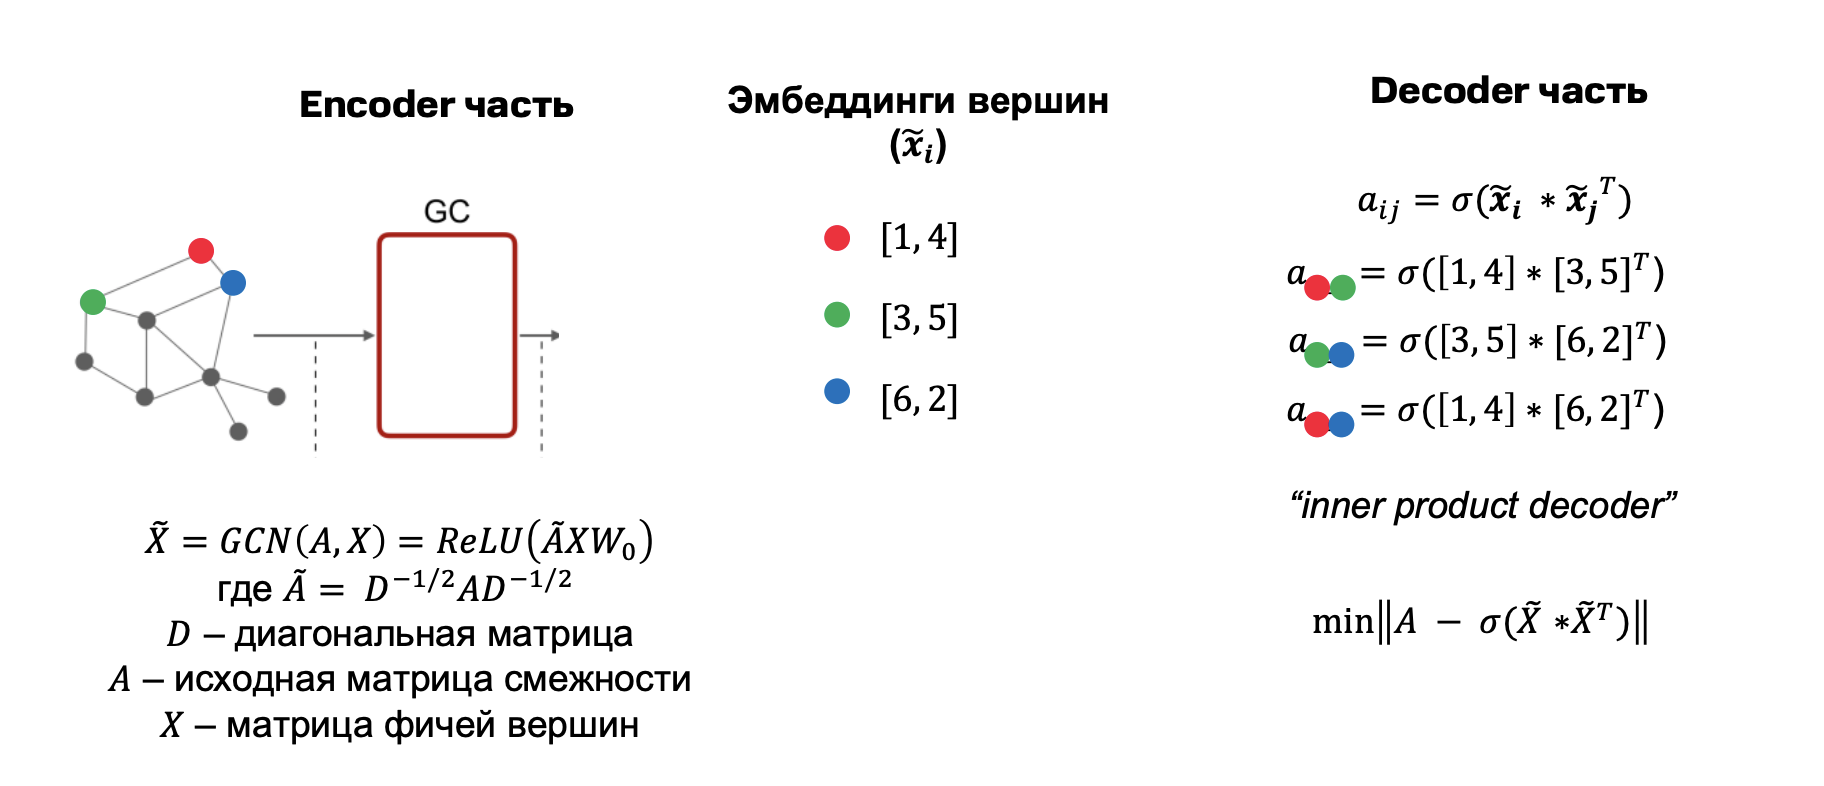

## VGAE (2016)

()
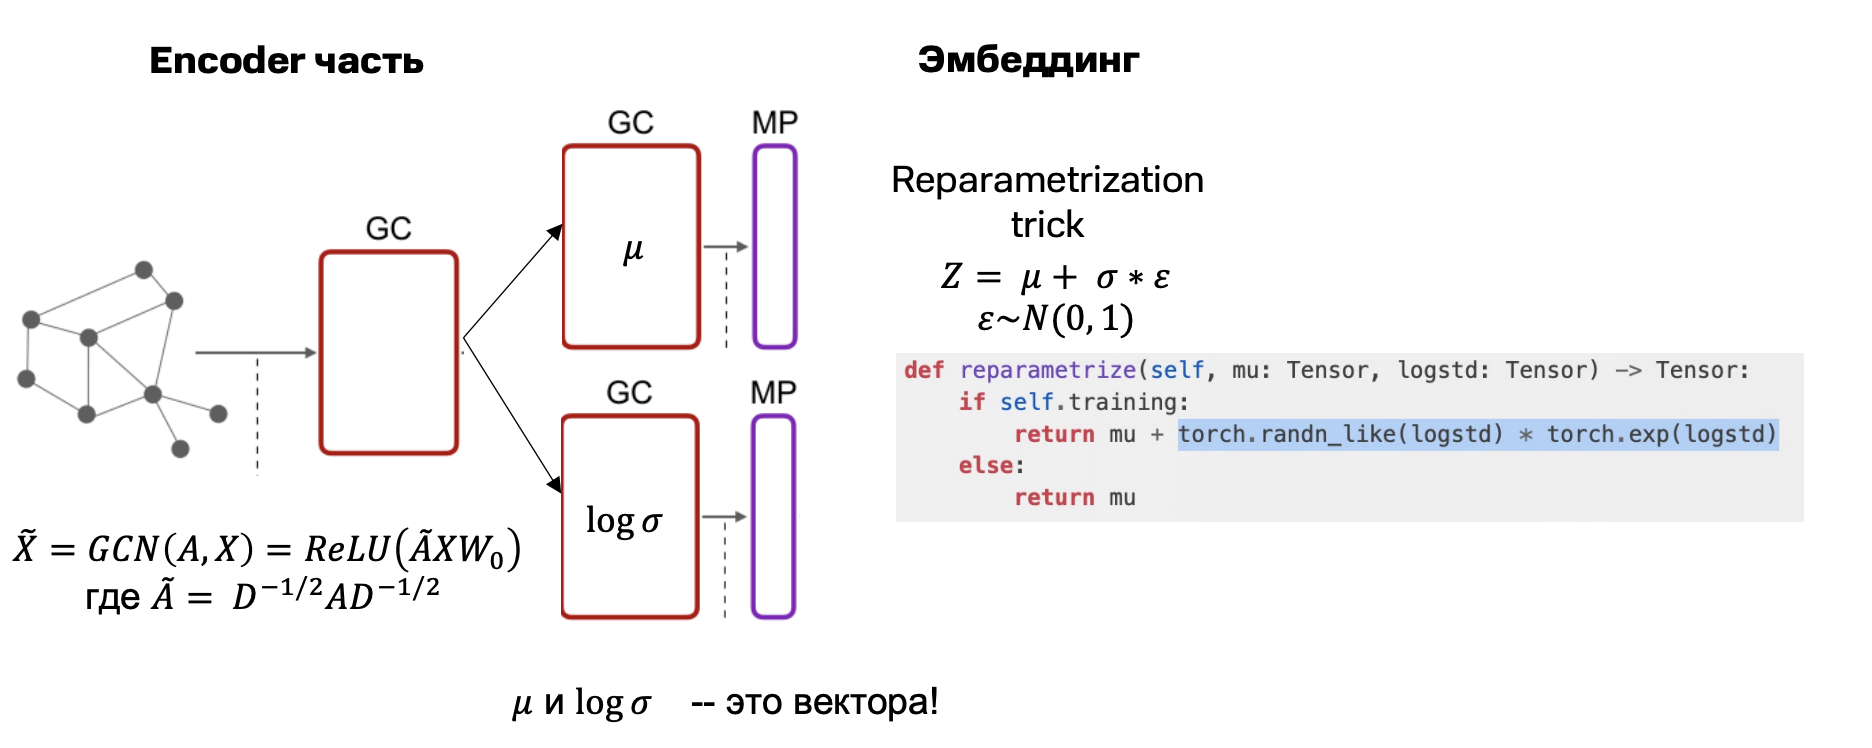

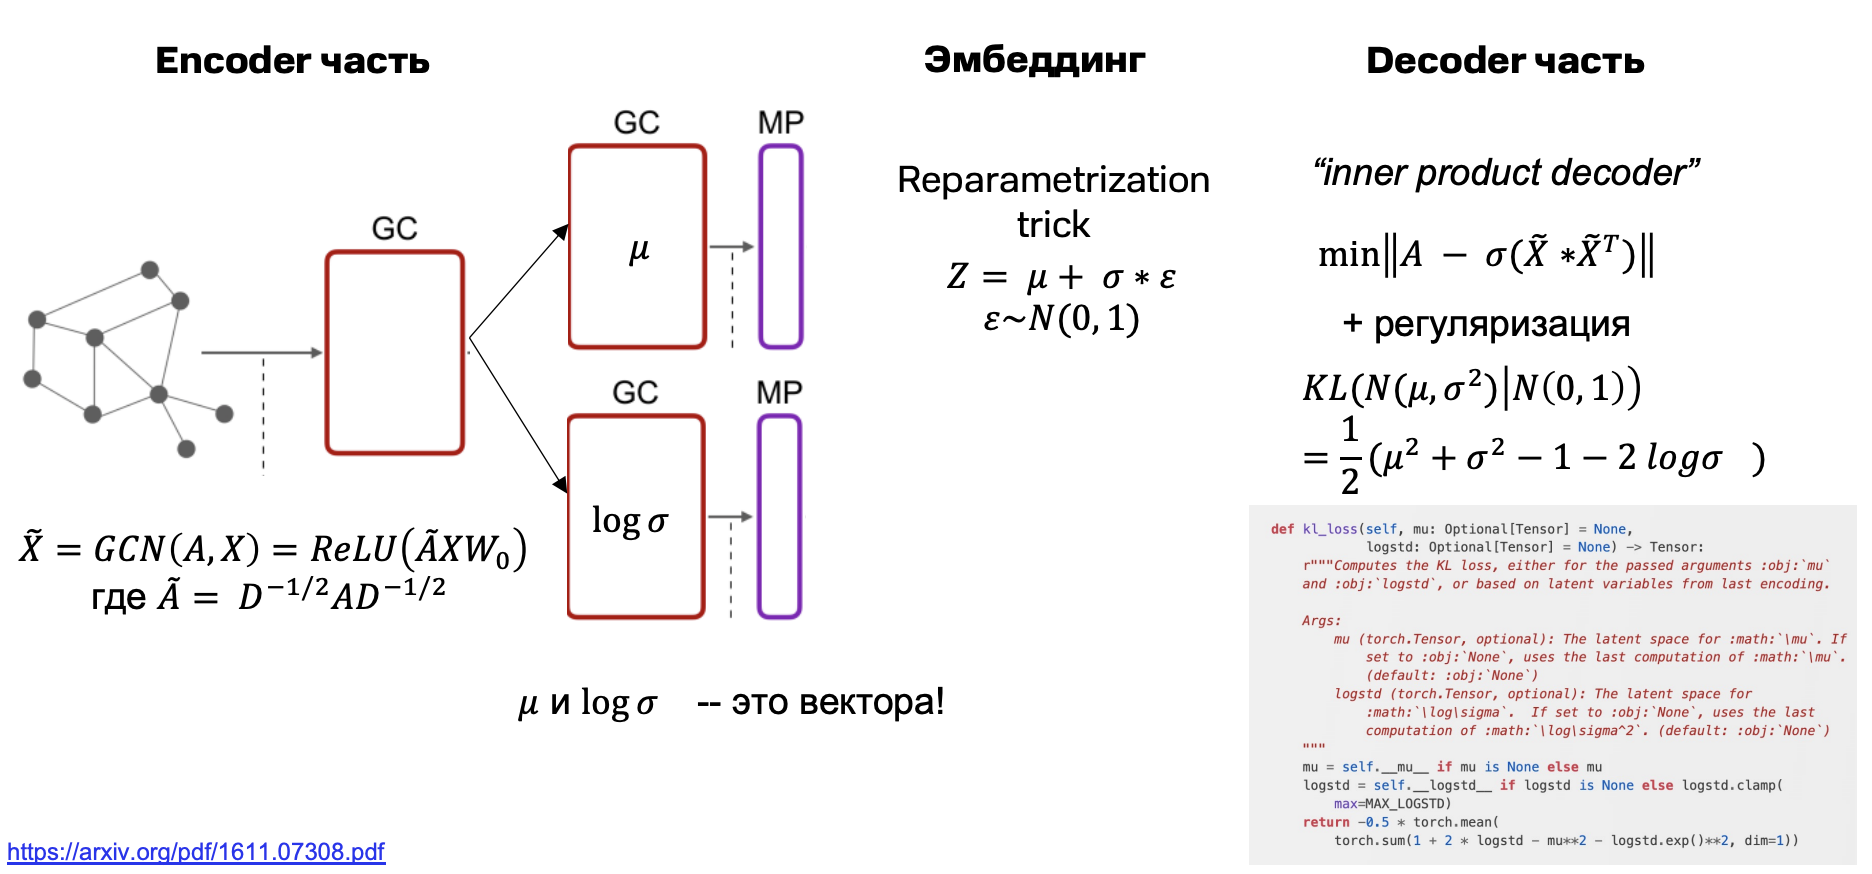

## CONAD


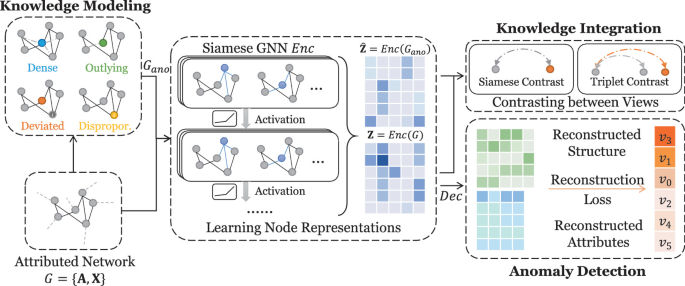

## Anomaly DAE


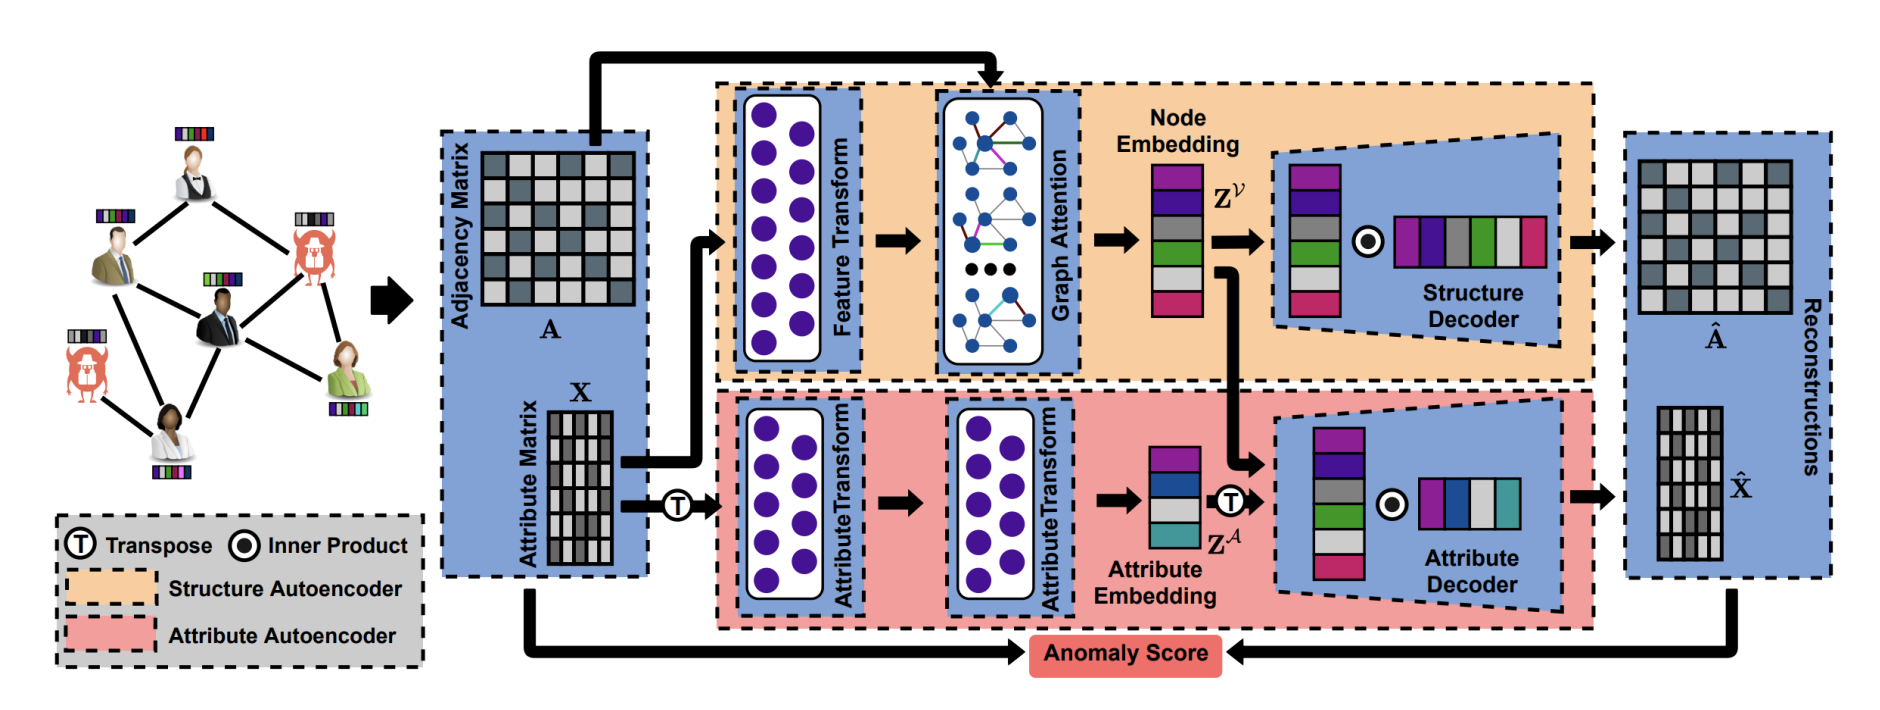

## DOMINANT model

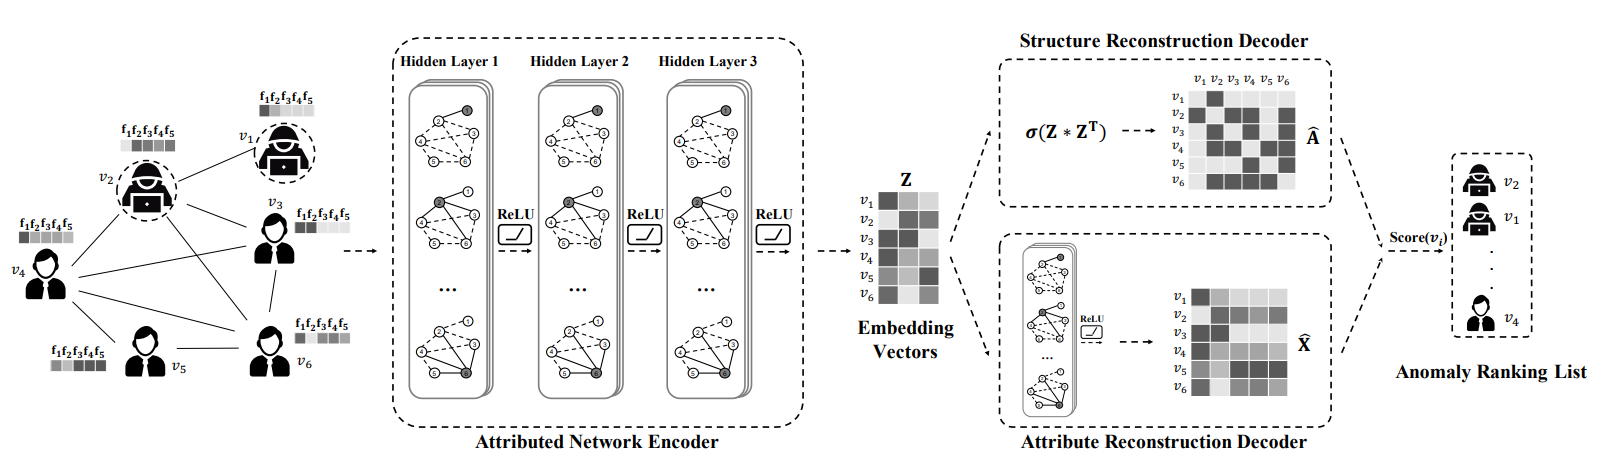

### Loss

\begin{align}
        L = (1 - \alpha)\mathbf{R}_s + \alpha\mathbf{R}_A  = (1 - \alpha)||\mathbf{A} -\widehat{\mathbf{A}}||_F^2 + \alpha||\mathbf{X} -\widehat{\mathbf{X}}||_F^2
\end{align}

\begin{align}
        score(\mathbf{v}_i) = (1 - \alpha)||\mathbf{a_i} -\widehat{\mathbf{a_i}}||^2 + \alpha||\mathbf{x_i} -\widehat{\mathbf{x_i}}||^2
\end{align}

https://github.com/pygod-team/pygod/tree/main/benchmark

In [ ]:
! python pygod/benchmark/main.py --dataset inj_cora --model dominant --gpu 0

100% 20/20 [04:33<00:00, 13.66s/it]
inj_cora DOMINANT AUC: 0.7489±0.0684 (0.8337)	AP: 0.1640±0.0448 (0.2108)	Recall: 0.2359±0.0740 (0.2971)


In [ ]:
! python pygod/benchmark/main.py --dataset inj_cora --model conad --gpu 0

100% 20/20 [10:50<00:00, 32.53s/it]
inj_cora CONAD AUC: 0.7866±0.0418 (0.8337)	AP: 0.1881±0.0275 (0.2108)	Recall: 0.2623±0.0460 (0.2971)


## 2.1. PyGOD in notebook

Datasets description  
https://github.com/pygod-team/data  

In [ ]:
import pandas as pd
import numpy as np
from sklearn.metrics import roc_auc_score
import pyod
from pygod.utils import load_data
from sklearn.ensemble import IsolationForest
from pyod.models.lof import LOF
from pygod.detector import DOMINANT, AnomalyDAE, CONAD, GAE

In [ ]:
def calc_node_degree(data):
    s = pd.DataFrame(data.edge_index.numpy().T).groupby(0)[1].count()

    degree = np.zeros(data.x.shape[0],dtype=int)
    degree[s.index] = s.values

    return degree

In [ ]:
def describe_data(data):
    print('========================')

    print(f'Number of nodes: {data.x.shape[0]}')
    print(f'Number of edges: {data.edge_index.shape[1]}')
    print(f'Number of features: {data.x.shape[1]}')

    if data.edge_attr is not None:
        print(f'Number of edge attributes: {data.edge_attr.shape[1]}')

    y = data.y.numpy()
    y = y[~np.isnan(y) & (y!=-100)]
    print(f'Number of classes: {len(np.unique(y))}')
    print('========================')

In [ ]:
def print_gini(data, score, model_type = ''):
    if not isinstance(score,np.ndarray):
        score = score.numpy()

    structural_mask = np.isin(data.y.numpy(),([0,2,3]))
    contextual_mask = np.isin(data.y.numpy(),([0,1,3]))
    y = data.y.bool().numpy().astype(int)

    gini_structural =  2*roc_auc_score(y[structural_mask], score[structural_mask])-1
    gini_contextual =  2*roc_auc_score(y[contextual_mask], score[contextual_mask])-1
    gini_total = 2*roc_auc_score(y, score)-1

    print("""GINI structural = {:.3f}
GINI contextual = {:.3f}
GINI total      = {:.3f}
    """.format(gini_structural, gini_contextual, gini_total))
    a, b, c = [round(x, 3) for x in [gini_structural, gini_contextual, gini_total]]
    return model_type, a, b, c

In [ ]:
def test_all_models(datasets):
  res_all = pd.DataFrame()
  for dataset in datasets:
    res = []
    data = load_data(dataset)
    describe_data(data)
    # - 0: inlier
    # - 1: contextual outlier only
    # - 2: structural outlier only
    # - 3: both contextual outlier and structural outlier

    # labels count
    # число представителей класса
    print(pd.Series(data.y.numpy()).value_counts())

    print('degree')
    degree = calc_node_degree(data)
    res.append(print_gini(data, degree, 'node_degree'))

    # without graph
    model = IsolationForest()
    model.fit(data.x.numpy())
    score = model.decision_function(data.x.numpy())
    print('IsolationForest')
    res.append(print_gini(data, score, 'IsolationForest'))

    # without graph
    model = LOF()
    model.fit(data.x.numpy())
    score = model.decision_function(data.x.numpy())
    print('LOF')
    res.append(print_gini(data, score, 'LOF'))

    # with graph
    gpu = 0 # <=> cuda
    # gpu = -1 # <=> cpu

    model = DOMINANT(gpu=gpu)
    model.fit(data)
    score = model.decision_score_.numpy()
    print('DOMINANT')
    res.append(print_gini(data, score, 'DOMINANT'))

    model = CONAD(gpu=gpu)
    model.fit(data)
    score = model.decision_score_.numpy()
    y =data.y.bool().numpy().astype(int)
    print('CONAD')
    res.append(print_gini(data, score, 'CONAD'))

    model = CONAD(gpu=gpu, eta = 0.2)
    model.fit(data)
    score = model.decision_score_.numpy()
    y =data.y.bool().numpy().astype(int)
    print('CONAD')
    res.append(print_gini(data, score, 'CONAD_02'))

    model = CONAD(gpu=gpu, eta = 0.8)
    model.fit(data)
    score = model.decision_score_.numpy()
    y =data.y.bool().numpy().astype(int)
    print('CONAD')
    res.append(print_gini(data, score, 'CONAD_08'))

    model = AnomalyDAE()
    model.fit(data)
    score = model.decision_score_.numpy()
    y =data.y.bool().numpy().astype(int)
    print('AnomalyDAE')
    res.append(print_gini(data, score, 'AnomalyDAE'))

    model = GAE(gpu=gpu)
    model.fit(data)
    score = model.decision_score_.numpy()
    y =data.y.bool().numpy().astype(int)
    print('GAE')
    res.append(print_gini(data, score, 'GAE'))

    res_pd = pd.DataFrame(res, columns = ['model', 'gini structural', 'gini contextual', 'gini total '])
    res_pd['dataset'] = dataset

    if res_all.shape[1] == 1:
      res_all = res_pd.copy()
    else:
      res_all = pd.concat([res_all, res_pd], ignore_index = True)
  return res_all

In [ ]:
test_all_models(['inj_cora', 'inj_amazon'])

Number of nodes: 2708
Number of edges: 11060
Number of features: 1433
Number of classes: 4
0    2570
1      68
2      68
3       2
Name: count, dtype: int64
degree
GINI structural = 0.918
GINI contextual = -0.004
GINI total      = 0.451
    
IsolationForest
GINI structural = 0.141
GINI contextual = 0.535
GINI total      = 0.330
    
LOF
GINI structural = 0.068
GINI contextual = 0.743
GINI total      = 0.398
    
DOMINANT
GINI structural = 0.922
GINI contextual = 0.161
GINI total      = 0.536
    
CONAD
GINI structural = 0.921
GINI contextual = 0.159
GINI total      = 0.534
    
CONAD
GINI structural = 0.921
GINI contextual = 0.156
GINI total      = 0.533
    
CONAD
GINI structural = 0.920
GINI contextual = 0.162
GINI total      = 0.535
    
AnomalyDAE
GINI structural = 0.142
GINI contextual = 0.678
GINI total      = 0.403
    
GAE
GINI structural = 0.082
GINI contextual = 0.776
GINI total      = 0.422
    
Number of nodes: 13752
Number of edges: 511042
Number of features: 767
Number of

,model,gini structural,gini contextual,gini total,dataset
0,node_degree,0.918,-0.004,0.451,inj_cora
1,IsolationForest,0.141,0.535,0.330,inj_cora
2,LOF,0.068,0.743,0.398,inj_cora
3,DOMINANT,0.922,0.161,0.536,inj_cora
4,CONAD,0.921,0.159,0.534,inj_cora
5,CONAD_02,0.921,0.156,0.533,inj_cora
6,CONAD_08,0.920,0.162,0.535,inj_cora
7,AnomalyDAE,0.142,0.678,0.403,inj_cora
8,GAE,0.082,0.776,0.422,inj_cora
9,node_degree,0.824,0.012,0.414,inj_amazon


## Датасет weibo

Weibo has organic outliers

Dataset from
Error-bounded graph anomaly loss for gnns.
T. Zhao, C. Deng, K. Yu, T. Jiang, D. Wang, and M. Jiang.
In Proceedings of the 29th ACM International Conference on Information & Knowledge Management, pages 1873–1882, 2020.
https://tzhao.io/files/papers/CIKM20_GAL.pdf

Tencent-Weibo is a user-posts-hashtag graph from a Twitter-like platform.
It has 8,405 users
There is an edge between 2 users if they used same hashtag in post.  
100 location features.   
300 bag-of-words features.  

In [ ]:
data = load_data('weibo')
describe_data(data)
# Доли классов
pd.Series(data.y.numpy()).value_counts(normalize=True).round(3)

Number of nodes: 8405
Number of edges: 407963
Number of features: 400
Number of classes: 2


0    0.959
1    0.041
Name: proportion, dtype: float64

In [ ]:
def print_gini_simple(data, score, model_type = ''):
  if not isinstance(score,np.ndarray):
          score = score.numpy()
  y = data.y.bool().numpy().astype(int)
  gini_total = 2 * roc_auc_score(y, score) - 1
  print(model_type)
  print( f'{gini_total:.3f}')
  return model_type, round(gini_total, 3)

In [ ]:
res = []
degree = calc_node_degree(data)
res.append(print_gini_simple(data, degree, 'node degree'))

model = LOF()
model.fit(data.x.numpy())
score = model.decision_function(data.x.numpy())
res.append(print_gini_simple(data, score, 'LOF'))

gpu = 0
model = AnomalyDAE(gpu=gpu)
model.fit(data)
score = model.decision_score_.numpy()
res.append(print_gini_simple(data, score, 'AnomalyDAE'))

model = CONAD(gpu=gpu)
model.fit(data)
score = model.decision_score_.numpy()
res.append(print_gini_simple(data, score, 'CONAD'))

model = DOMINANT(gpu=gpu)
model.fit(data)
score = model.decision_score_.numpy()
res.append(print_gini_simple(data, score, 'DOMINANT'))

from pygod.detector import Radar
model = Radar(gpu=gpu)

model.fit(data)
score = model.decision_score_.numpy()
res.append(print_gini_simple(data, score, 'Radar'))

node degree
-0.711
LOF
0.154
AnomalyDAE
0.448
CONAD
0.775
DOMINANT
0.775
Radar
0.899


In [ ]:
res_pd = pd.DataFrame(res, columns = ['model', 'gini total '])
res_pd

,model,gini total
0,node degree,-0.711
1,LOF,0.154
2,AnomalyDAE,0.448
3,CONAD,0.775
4,DOMINANT,0.775
5,Radar,0.899


## 2.2. BOND   
https://www.cs.cmu.edu/~zhihaoj2/papers/Bond_NeurIPS22.pdf


→ Нет универсального метода – зависит и от задачи (структурные аномалии или
контекстные) и датасета.  
→ Ближайшего окружения (1-hop) как правило достаточно для детекции
структурных выбросов   
→ DL-методы менее стабильны в терминах дисперсии ROC-AUC.        
→ На маленьких графах DL-методы проигрывают классическим   

# 3. Домашнее задание. [COLES](https://arxiv.org/pdf/2002.08232.pdf) и [PTLS](https://github.com/dllllb/pytorch-lifestream/)

Часто данные предсталены в виде транзакций, со своими атрибутами, в тч временными, в случае ЮЛ между вершинами может быть несколько транзакций и можно решать как графовую задачу, так и транзакционную.

I. Задание на выбор:    

1) Сравнить VAE vs COLES (SSL транзакционные эмбеддинги) + (V)AE vs COLES + классика (любая) vs что понравилось с семинара vs Supervised в задаче [фродовых транзакций ФЛ](https://github.com/atavci/fraud-detection-on-banksim-data/blob/master/Data/)


2) сравнить табличные unsupervised детекторы аномалий на
[альтернативном датасете](https://github.com/jeffprosise/Machine-Learning/blob/master/Data/creditcard.zip) где побольше фичей и поменьше транзакций, но нет клиентов

3) кто не хочет в синтетику -- вот [реальный датасет](https://www.kaggle.com/datasets/ellipticco/elliptic-data-set)
и [бонус](https://www.kaggle.com/datasets/alexbenzik/deanonymized-995-pct-of-elliptic-transactions) для тех, кто увлекается темой, транзакция здесь является вершиной (!)


II. Задание на выбор

1) в PYOD beta-VAE написан на keras, реализуйте на torch отправьте и MR в PYOD

2) сравнить быстродействие PYOD vs PYTOD на [датасете](https://github.com/jeffprosise/Machine-Learning/blob/master/Data/creditcard.zip) на 10 алгоритмах на ваш выбор


